## 1. Loading libraries

In [3]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns

np.warnings = warnings

In [4]:
import sys
sys.path.append("..")

# import utility functions
import src.utils as util
reload(util)

import src.load_parquet as load_parquet
reload(load_parquet)

# setup OS agnostic pathnames
ROOT_DIR = Path('..')

# Note: to run main notebook from root directory, use:
# ROOT_DIR = Path('')

In [26]:
# load libraries and modules
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score,RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report 
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, accuracy_score, classification_report

## 2. Train/ Test Split

In [16]:
path_t0_df = ROOT_DIR / 'data' / "t0.csv"  
t0_df = pd.read_csv(path_t0_df)
t0_df

,SUBJECT_ID,HADM_ID,IS_SEPSIS,ITEMID_50912,ITEMID_50931,ITEMID_51006,ITEMID_51221,ITEMID_51222,ITEMID_51244,ITEMID_51256,ITEMID_51274,ITEMID_51279,ITEMID_51301,AGE,GENDER_NUM
0,2,163353,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,0,0
1,3,145834,0,3.2,91.0,53.0,30.2,10.0,8.0,81.0,13.5,3.44,12.7,76,0
2,4,185777,0,0.5,140.0,9.0,34.2,11.5,6.9,89.6,-999.0,3.80,9.7,47,1
3,5,178980,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,0,0
4,7,118037,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46043,99983,117390,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,78,0
46044,99985,176670,1,-999.0,-999.0,-999.0,36.4,12.4,8.1,85.1,-999.0,4.20,13.0,53,0
46045,99991,151118,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,47,0
46046,99992,197084,0,1.2,206.0,56.0,12.9,4.7,9.1,84.9,12.9,1.35,21.4,65,1


In [17]:
X_t0_train, X_t0_test, y_t0_train, y_t0_test = train_test_split(
    t0_df.drop('IS_SEPSIS', axis=1),  # dropping the target column for X values
    t0_df['IS_SEPSIS'],
    test_size=0.2,  # this means 20% test set
    stratify=t0_df['IS_SEPSIS'],  # stratify by the target variable
    random_state=42  # to ensure reproducibility
)

# If you want to get the train and test set as dataframes:
train_t0_df = pd.concat([X_t0_train, y_t0_train], axis=1)
test_t0_df = pd.concat([X_t0_test, y_t0_test], axis=1)

train_t0_df

,SUBJECT_ID,HADM_ID,ITEMID_50912,ITEMID_50931,ITEMID_51006,ITEMID_51221,ITEMID_51222,ITEMID_51244,ITEMID_51256,ITEMID_51274,ITEMID_51279,ITEMID_51301,AGE,GENDER_NUM,IS_SEPSIS
4303,4669,155461,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,51,0,0
34546,54946,176771,2.3,86.0,42.0,27.6,9.3,5.4,91.3,-999.0,2.80,17.6,84,0,0
20956,22434,158881,0.7,112.0,9.0,38.6,13.2,3.6,94.1,12.7,4.49,12.0,82,1,0
9544,10167,187932,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,81,0,0
640,674,116577,1.3,102.0,34.0,34.4,11.5,26.2,66.8,25.5,3.60,7.7,78,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16734,17886,148830,1.3,207.0,30.0,47.1,15.3,27.0,64.8,13.4,5.06,23.1,76,0,0
39431,73913,161612,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,67,1,0
41025,80248,153030,0.8,100.0,9.0,45.7,16.1,13.0,77.2,-999.0,5.20,11.2,55,0,0
2585,2797,180101,0.7,165.0,23.0,25.8,7.6,2.0,88.0,-999.0,3.22,19.6,55,1,0


In [18]:
# Counting the number of instance in each class in the training dataset
label_counts = train_t0_df["IS_SEPSIS"].value_counts()
label_proportions = label_counts / len(train_t0_df)*100

label_info = pd.DataFrame({'Count': label_counts, 'Proportion': label_proportions.map("{:.2f}%".format)})
print(label_info)

           Count Proportion
IS_SEPSIS                  
0          33168     90.04%
1           3670      9.96%


## 3. Features Scaling

In [21]:
t0_df.describe()

,SUBJECT_ID,HADM_ID,IS_SEPSIS,ITEMID_50912,ITEMID_50931,ITEMID_51006,ITEMID_51221,ITEMID_51222,ITEMID_51244,ITEMID_51256,ITEMID_51274,ITEMID_51279,ITEMID_51301,AGE,GENDER_NUM
count,46048.000000,46048.000000,46048.000000,46048.000000,46048.000000,46048.000000,46048.000000,46048.000000,46048.000000,46048.000000,46048.000000,46048.000000,46048.000000,46048.000000,46048.000000
mean,34217.564997,149976.126346,0.099635,-362.573592,-354.272694,-345.713560,-307.444499,-326.883647,-454.075482,-424.016524,-515.676417,-333.091724,-325.801632,52.979760,0.445079
std,28196.008487,28860.812900,0.299516,481.445342,580.048979,495.081338,487.532943,477.374816,507.126917,535.132736,507.112708,473.791189,476.906433,26.412991,0.496980
min,2.000000,100001.000000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.000000
25%,12231.250000,124948.750000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,42.000000,0.000000
50%,24614.500000,149982.500000,0.000000,0.800000,91.000000,14.000000,31.600000,10.500000,3.300000,41.050000,-999.000000,3.480000,7.300000,61.000000,0.000000
75%,54922.000000,174946.250000,0.000000,1.200000,133.000000,25.000000,38.500000,13.000000,14.200000,79.600000,13.300000,4.280000,11.900000,73.000000,1.000000
max,99995.000000,199999.000000,1.000000,43.000000,2340.000000,274.000000,75.000000,24.400000,100.000000,99.000000,150.000000,8.970000,846.700000,89.000000,1.000000


In [19]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalisation
X_t0_train = scaler.fit_transform(X_t0_train)
X_t0_test = scaler.transform(X_t0_test)

## 4. Model Fitting

### 4.1 Logistic Regression

In [22]:
# Fitting a Logistic Regression Classifier
t0_lr = LogisticRegression(random_state=901)
t0_lr.fit(X_t0_train, y_t0_train)

LogisticRegression(random_state=901)

In [24]:
# Looking at some predictions from the testing set
some_data = X_t0_test[:5]
some_labels = y_t0_test[:5]
print("Predictions:", t0_lr.predict(some_data))
print("Labels:", some_labels.values.flatten().tolist())

Predictions: [0 0 0 0 0]
Labels: [0, 0, 0, 1, 0]


In [28]:
# Computing the confusion matrix
t0_lr_predictions = t0_lr.predict(X_t0_test)
print("Preliminary performance measures for Logistic Regression Classifier:\n")
print("Confusion Matrix: ")
print(confusion_matrix(y_t0_test, t0_lr_predictions))

# Computing the accuracy score
t0_lr_score = t0_lr.score(X_t0_test, y_t0_test)
print("\nAccuracy score: {:.4f}".format(t0_lr_score))

# Computing the root mean squared error (RMSE)
t0_lr_mse = mean_squared_error(y_t0_test, t0_lr_predictions) 
t0_lr_rmse = np.sqrt(t0_lr_mse)
print("RMSE: {:.4f}".format(t0_lr_rmse))

Preliminary performance measures for Logistic Regression Classifier:

Confusion Matrix: 
[[8292    0]
 [ 918    0]]

Accuracy score: 0.9003
RMSE: 0.3157


Performance measures on Logistic Regression Classifier:



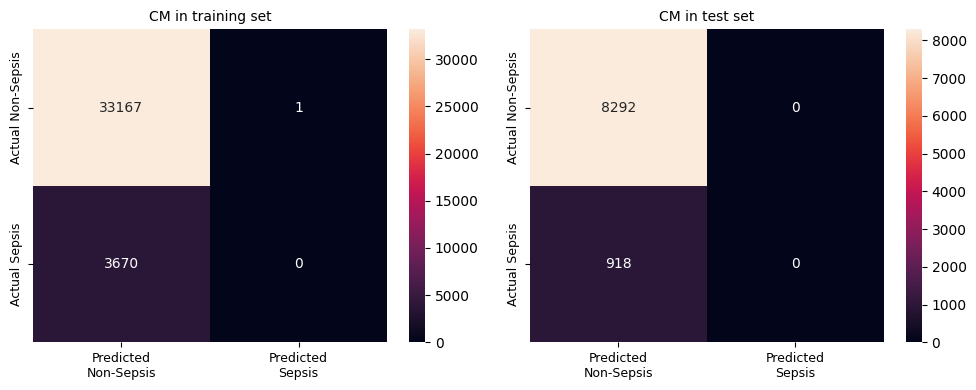


Precision: Training set 0.0000 ; Test set 0.0000
Recall: Training set 0.0000 ; Test set 0.0000
Predictive value of a negative test: Training set 0.9004 ; Test set 0.9003


/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
# Function for performance measures on (i) confusion matrix, (ii) precision, (iii) recall and (iv) NPV
def performance_measure(model, X_train, X_test, y_train, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Computating the confusion matrix
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)    

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    
    x_labels = ["Predicted\nNon-Sepsis", "Predicted\nSepsis"]
    y_labels = ["Actual Non-Sepsis", "Actual Sepsis"]
    sns.heatmap(cm_train, annot=True, fmt='d', xticklabels=x_labels, yticklabels=y_labels, ax=axes[0])
    sns.heatmap(cm_test, annot=True, fmt='d', xticklabels=x_labels, yticklabels=y_labels, ax=axes[1])
    
    axes[0].set_title("CM in training set", fontsize = 10)
    axes[1].set_title("CM in test set", fontsize = 10)
    axes[0].tick_params(labelsize=9)
    axes[1].tick_params(labelsize=9)
    plt.tight_layout()
    plt.show()    

    # Computing precision and recall
    precision_train = precision_score(y_train, y_pred_train)
    precision_test = precision_score(y_test, y_pred_test)
    recall_train = recall_score(y_train, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)
    print("\nPrecision: Training set {:.4f}".format(precision_train), "; Test set {:.4f}".format(precision_test))
    print("Recall: Training set {:.4f}".format(recall_train), "; Test set {:.4f}".format(recall_test))

     # Computing predictive values of a negative test
    tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_pred_train).ravel()
    NPV_train = tn_train / (tn_train + fn_train)
    tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()
    NPV_test = tn_test / (tn_test + fn_test)
    print("Predictive value of a negative test: Training set {:.4f}".format(NPV_train), "; Test set {:.4f}".format(NPV_test))

print("Performance measures on Logistic Regression Classifier:\n")
performance_measure(t0_lr, X_t0_train, X_t0_test, y_t0_train, y_t0_test)